In [ ]:
pip install seaborn

In [94]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import requests
from config import api_key
from sklearn.linear_model import LinearRegression
from datetime import datetime
import math
import seaborn as sns

# Save config information.
base_url = "http://api.openweathermap.org/data/2.5/weather?"
#url2 = "http://api.openweathermap.org/data/2.5/air_pollution?"
units = "imperial"


# Build partial query URL
query_url = f"{base_url}appid={api_key}&units={units}&q="
#quary_url2 = f"{url2}appid={api_key}&lat={lat}&lon={lon}&q="

# insert data files and pathways
fire_data_path = "Resources/ODF_Fire_Data.csv"
# read the fire data
fire_data  = pd.read_csv(fire_data_path)

# display the fire data
fire_data


,Serial,FireCategory,FireYear,Area,DistrictName,UnitName,FullFireNumber,FireName,Size_class,EstTotalAcres,...,Industrial_Restriction,Ign_DateTime,ReportDateTime,Discover_DateTime,Control_DateTime,CreationDate,ModifiedDate,DistrictCode,UnitCode,DistFireNumber
0,58256,STAT,2000,EOA,Central Oregon,John Day,00-952011-01,Slick Ear #2,B,0.75,...,Does Not Apply - Eastern OR,07/18/2000 07:00:00 PM,07/19/2000 01:20:00 PM,07/19/2000 01:15:00 PM,07/20/2000 12:50:00 AM,07/20/2000 09:13:00 AM,11/14/2000 09:16:00 AM,95,952,011
1,59312,STAT,2000,EOA,Northeast Oregon,La Grande,00-971024-01,Woodley,C,80.00,...,Does Not Apply - Eastern OR,08/24/2000 05:30:00 AM,08/24/2000 01:07:00 PM,08/24/2000 01:07:00 PM,09/01/2000 09:30:00 PM,08/29/2000 03:59:00 PM,12/21/2000 04:22:00 PM,97,971,024
2,61657,STAT,2001,SOA,Southwest Oregon,Grants Pass,01-712133-02,QUEENS BRANCH,A,0.10,...,Lvl 3 Restricted Shutdown,08/10/2001 05:40:00 PM,08/10/2001 05:47:00 PM,08/10/2001 05:45:00 PM,08/10/2001 06:30:00 PM,08/10/2001 06:42:00 PM,08/17/2001 11:45:00 AM,71,712,133
3,63735,STAT,2002,NOA,West Oregon,Philomath,02-551001-03,WREN,A,0.01,...,Lvl 1 Fire Season Only,07/06/2002 01:01:00 PM,07/06/2002 01:04:00 PM,07/06/2002 01:02:00 PM,07/06/2002 01:07:00 PM,07/07/2002 09:16:00 AM,07/28/2002 10:08:00 AM,55,551,001
4,68019,STAT,2003,NOA,West Oregon,Dallas,03-552013-04,Ritner Creek,A,0.01,...,Lvl 3 Restricted Shutdown,08/22/2003 04:00:00 AM,08/22/2003 05:00:00 AM,08/22/2003 05:00:00 AM,08/22/2003 09:30:00 AM,08/22/2003 04:12:00 PM,09/04/2003 09:39:00 AM,55,552,013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,124548,STAT,2021,EOA,Walker Range - WRFPA,Crescent,21-991258-21,Road 2430,B,0.75,...,Does Not Apply - Eastern OR,06/26/2021 04:00:00 PM,06/26/2021 04:58:00 PM,06/26/2021 04:45:00 PM,06/26/2021 09:58:00 PM,07/01/2021 12:00:00 AM,10/02/2021 03:08:00 PM,99,991,258
23486,132141,STAT,2022,SOA,Western Lane,Veneta,22-781066-23,Spruce Path,A,0.01,...,Lvl 1 Fire Season Only,09/13/2022 11:20:00 AM,09/13/2022 11:20:00 AM,09/13/2022 11:20:00 AM,09/13/2022 12:14:00 PM,09/13/2022 12:00:00 AM,09/19/2022 10:09:00 AM,78,781,066
23487,124065,STAT,2021,EOA,Northeast Oregon,Pendleton,21-973052-21,Bone Canyon,C,67.43,...,Does Not Apply - Eastern OR,06/13/2021 05:22:00 PM,06/14/2021 12:45:00 PM,06/14/2021 12:45:00 PM,06/17/2021 05:10:00 PM,06/14/2021 12:00:00 AM,09/24/2021 01:48:00 PM,97,973,052
23488,131292,STAT,2022,EOA,Northeast Oregon,Pendleton,22-973014-23,Milepost 231,A,0.10,...,Does Not Apply - Eastern OR,08/19/2022 03:09:00 PM,08/19/2022 03:09:00 PM,08/19/2022 03:09:00 PM,08/19/2022 04:41:00 PM,08/19/2022 12:00:00 AM,11/08/2022 11:34:00 AM,97,973,014


In [95]:
def get_air_quality_data(api_key, lat, lon, start_epoch, end_epoch):
    url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start_epoch}&end={end_epoch}&appid={api_key}"
    response = requests.get(url)
    data = response.json()
    return data

def extract_air_quality_data(data):
    air_quality_data = []
    daily_aqi = {}  # To store the sum of AQI values for each day
    daily_counts = {}  # To store the count of data points for each day
    for item in data["list"]:
        timestamp = pd.Timestamp.fromtimestamp(item["dt"])
        date = timestamp.date()
        aqi = item["main"]["aqi"]

        # Calculate the sum and count for each day
        if date in daily_aqi:
            daily_aqi[date] += aqi
            daily_counts[date] += 1
        else:
            daily_aqi[date] = aqi
            daily_counts[date] = 1

    # Calculate the average AQI for each day
    for date in daily_aqi:
        average_aqi = daily_aqi[date] / daily_counts[date]
        daily_aqi[date] = math.ceil(average_aqi)

        air_quality_data.append({
            "Date": date,
            "Month": date.month,
            "AQI": daily_aqi[date],
        })
    return air_quality_data

# Replace the API key, latitude, and longitude with your actual values
api_key = "2a7b4cc4913b8dfaeb15dacfe2287b16"
lat = 45.523064  # Portland, Oregon latitude
lon = -122.676483  # Portland, Oregon longitude
start_epoch = 1483228800  # January 1, 2017, 00:00:00 UTC
end_epoch = 1672435199  # December 31, 2022, 23:59:59 UTC

data = get_air_quality_data(api_key, lat, lon, start_epoch, end_epoch)
portland_air_quality_data = extract_air_quality_data(data)
portland_df = pd.DataFrame(portland_air_quality_data)

# Group data by Month and AQI, and calculate the count for each combination
monthly_aqi_counts = portland_df.groupby(['Month', 'AQI']).size().unstack(fill_value=0)

monthly_aqi_counts


AQI,1,2,3,4,5
Month,,,,,
1,9,37,7,8,1
2,11,33,9,3,0
3,7,39,10,6,0
4,3,55,2,0,0
5,15,47,0,0,0
6,16,41,3,0,0
7,15,45,1,0,0
8,10,46,4,2,0
9,10,45,4,1,0


<Figure size 1600x600 with 0 Axes>

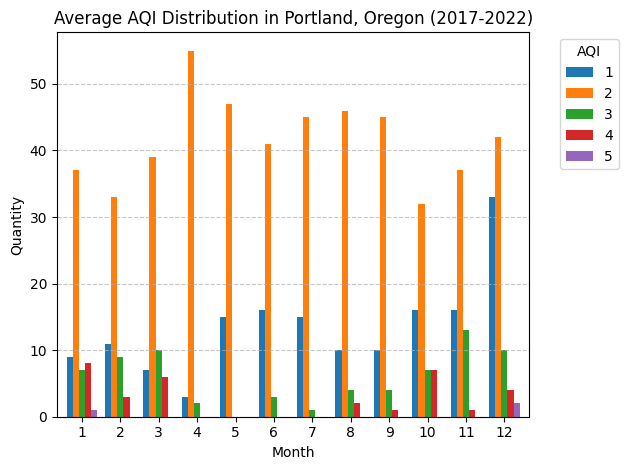

In [96]:
# Group data by Month and AQI, and calculate the count for each combination
monthly_aqi_counts = portland_df.groupby(['Month', 'AQI']).size().unstack(fill_value=0)

# Create a side-by-side bar chart for AQI counts for each month
plt.figure(figsize=(16, 6))
monthly_aqi_counts.plot(kind='bar', width=0.8)
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.title("Average AQI Distribution in Portland, Oregon (2017-2022)")
plt.legend(title="AQI", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [102]:
def get_air_quality_data(api_key, lat, lon, start_epoch, end_epoch):
    url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start_epoch}&end={end_epoch}&appid={api_key}"
    response = requests.get(url)
    data = response.json()
    return data

def extract_air_quality_data(data):
    air_quality_data = []
    daily_aqi = {}  # To store the sum of AQI values for each day
    daily_counts = {}  # To store the count of data points for each day
    for item in data["list"]:
        timestamp = pd.Timestamp.fromtimestamp(item["dt"])
        date = timestamp.date()
        aqi = item["main"]["aqi"]

        # Calculate the sum and count for each day
        if date in daily_aqi:
            daily_aqi[date] += aqi
            daily_counts[date] += 1
        else:
            daily_aqi[date] = aqi
            daily_counts[date] = 1

    # Calculate the average AQI for each day
    for date in daily_aqi:
        average_aqi = daily_aqi[date] / daily_counts[date]
        daily_aqi[date] = math.ceil(average_aqi)

        air_quality_data.append({
            "Date": date,
            "Year": date.year,
            "Month": date.month,
            "AQI": daily_aqi[date],
        })
    return air_quality_data

# Replace the API key, latitude, and longitude with your actual values
api_key = "2a7b4cc4913b8dfaeb15dacfe2287b16"
lat = 44.058174  # Bend, Oregon latitude
lon = -121.315308  # Bend, Oregon longitude
start_epoch = 1483228800  # January 1, 2017, 00:00:00 UTC
end_epoch = 1672435199  # December 31, 2022, 23:59:59 UTC

data = get_air_quality_data(api_key, lat, lon, start_epoch, end_epoch)
bend_air_quality_data = extract_air_quality_data(data)
bend_df = pd.DataFrame(bend_air_quality_data)

# Group data by Month and AQI, and calculate the count for each combination
monthly_aqi_counts = bend_df.groupby(['Month', 'AQI']).size().unstack(fill_value=0)

monthly_aqi_counts

AQI,1,2,3,4,5
Month,,,,,
1,40,22,0,0,0
2,21,35,0,0,0
3,8,54,0,0,0
4,3,57,0,0,0
5,21,41,0,0,0
6,30,30,0,0,0
7,17,41,2,1,0
8,7,46,4,5,0
9,10,37,7,3,3


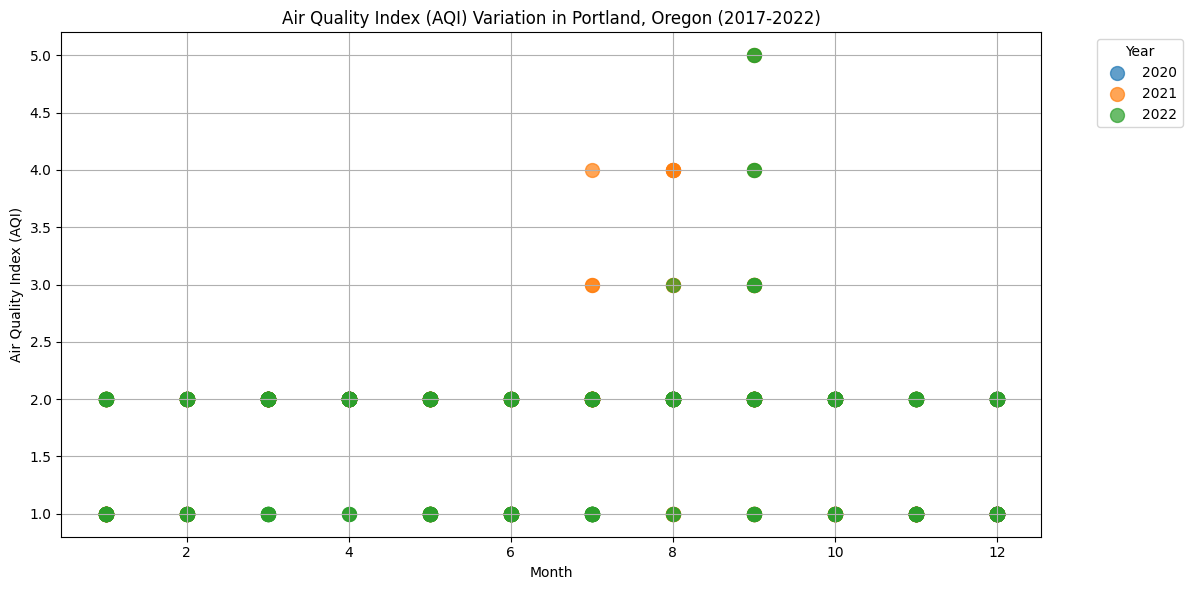

In [105]:
# Create a scatter plot for AQI over months with each year represented with a different color
plt.figure(figsize=(12, 6))

# Loop through unique years and plot data points with different colors for each year
for year in bend_df["Year"].unique():
    year_data = bend_df[bend_df["Year"] == year]
    plt.scatter(year_data["Month"], year_data["AQI"], label=year, s=100, alpha=0.7)

plt.xlabel("Month")
plt.ylabel("Air Quality Index (AQI)")
plt.title("Air Quality Index (AQI) Variation in Portland, Oregon (2017-2022)")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()